# Reference
https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb

In [ ]:
import os 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

### 影像前處理

In [ ]:
def processing_image(img_path):
    #讀取影向並縮放到預設大小
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img) #轉換為numpy陣列
    x = np.expand_dims(x, axis=0) #增加batch維度
    x = preprocess_input(x) #標準化影像(BGR排序, 減去均值)
    return x

### Grad-CAM

In [ ]:
def gradcam(model, x):
    #取得預測結果並選擇最高機率的類別
    preds = model(x)
    pred_class = tf.argmax(preds[0]) #取得最大機率的類別索引

    #取得最後一個捲積層
    last_conv_layer = model.get_layer('conv5_block3_out')
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    #使用gradientTape追蹤梯度
    with tf.GradientTape() as tape:
        conv_output, predictionos = grad_model(x) #前向傳播
        loss = predictionos[:, pred_class] #只針對預測類別計算梯度

    #計算梯度
    grads = tape.gradient(loss, conv_output)

    #計算全局平均池化(Global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    #乘以feature map凸顯重要區域
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    return heatmap.numpy(), imagenet_utils.decode_predictions(preds.numpy())[0][0][1]


### heatmap visualization

In [ ]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    heatmap = np.maximum(heatmap, 0) #ReLU確保非負數
    heatmap = np.nan_to_num(heatmap) #處理可能的NaN

    #去掉batch維度確保是2D
    heatmap = np.squeeze(heatmap) #(1,7,7)->(7,7)

    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap) #正規畫到0-1
    else:
        heatmap = np.zeros_like(heatmap) #避免除以0

    heatmap = np.uint8(255* heatmap)

    print(f"heatmap.shape before colormap: {heatmap.shape}")

    if len(heatmap.shape) == 2:
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    #讀取原始影像
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #opencv預設BGR，須轉RGB

    #調整heatmap尺寸匹配原圖
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # heatmap = np.uint8(255* heatmap) #轉為0-255

    #設定colormap
    if heatmap.shape[-1] != 3:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR)

    #疊加原始圖片與熱力圖    
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0) #疊加熱力圖

    #show
    plt.imshow(superimposed_img)
    plt.title(pred_class_name)
    plt.axis('off')
    plt.show()


### Imagenet pretrain ResNet50 conduct Grand-CAM

/home/guest/r13946008/miniconda3/envs/project/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_354']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


heatmap.shape before colormap: (7, 7)


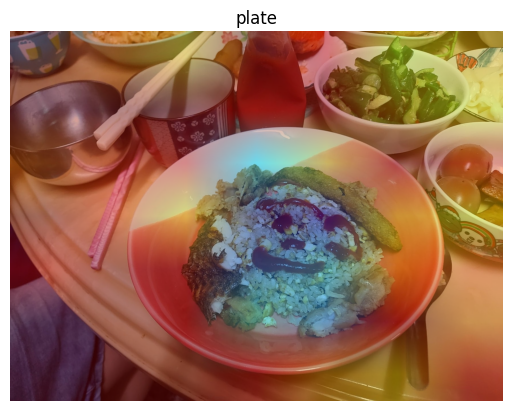

In [ ]:
model = ResNet50(weights='imagenet')
img_path = './food.jpg'
img = processing_image(img_path)
heatmap, pred_class_name = gradcam(model, img)
plot_heatmap(heatmap, img_path, pred_class_name)